<a href="https://colab.research.google.com/github/jusscarrascosa/brain-tumor-classification-vgg16/blob/main/Clasificacion_Automatica_de_TC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,
                             recall_score,
                             confusion_matrix)
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

###Descripcion de la base de datos

Para este trabajo se utilizó un conjunto de datos de Kaggle que contiene imágenes de resonancia magnética cerebral. Este dataset cuenta con un total de 7,023 imágenes de MRI de cerebros humanos, clasificadas en cuatro categorías: glioma, meningioma, tumor pituitario y ausencia de tumor.

En la descripcion de esta base de datos no se aclaraba si las imagenes estaban separadas en test y train, entonces habia que chequear

In [ ]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
import os

for root, dirs, files in os.walk(path):
    print(f"Directorio: {root}")
    for d in dirs:
        print(f"  Carpeta: {d}")
    for f in files:
        print(f"  Archivo: {f}")
    break

Directorio: /kaggle/input/brain-tumor-mri-dataset
  Carpeta: Training
  Carpeta: Testing


## Preprocesamiento de imagenes

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # para que las etiquetas coincidan con las predicciones
)




Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
print(train_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Balanceo de Clases

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Obtener las etiquetas de entrenamiento
y_train_labels = train_generator.classes

# Calcular pesos balanceados
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

# Convertir a diccionario
class_weights = dict(enumerate(class_weights))
print("Pesos de clase:", class_weights)


Pesos de clase: {0: np.float64(1.080999242997729), 1: np.float64(1.0664675130694548), 2: np.float64(0.8952978056426333), 3: np.float64(0.9800960878517502)}


Entrenamiento: {'pituitary': 1457, 'notumor': 1595, 'meningioma': 1339, 'glioma': 1321}
Test: {'pituitary': 300, 'notumor': 405, 'meningioma': 306, 'glioma': 300}


/tmp/ipython-input-76684194.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(conteo_train.keys(), rotation=45)
/tmp/ipython-input-76684194.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(conteo_test.keys(), rotation=45)


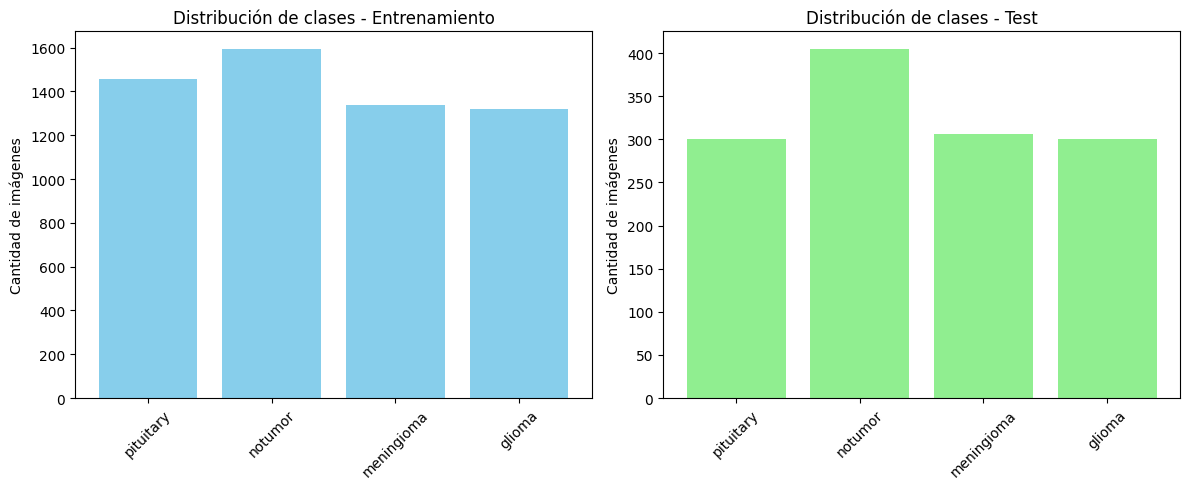

In [ ]:
import os
import matplotlib.pyplot as plt

# Rutas a tus carpetas
train_path = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"

def contar_imagenes_por_clase(path):
    clases = os.listdir(path)
    conteo = {}
    for clase in clases:
        clase_path = os.path.join(path, clase)
        if os.path.isdir(clase_path):
            n = len(os.listdir(clase_path))
            conteo[clase] = n
    return conteo

# Contar imágenes
conteo_train = contar_imagenes_por_clase(train_path)
conteo_test = contar_imagenes_por_clase(test_path)

# Mostrar conteos
print("Entrenamiento:", conteo_train)
print("Test:", conteo_test)

# Gráfico de barras
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico para entrenamiento
axs[0].bar(conteo_train.keys(), conteo_train.values(), color='skyblue')
axs[0].set_title("Distribución de clases - Entrenamiento")
axs[0].set_ylabel("Cantidad de imágenes")
axs[0].set_xticklabels(conteo_train.keys(), rotation=45)

# Gráfico para test
axs[1].bar(conteo_test.keys(), conteo_test.values(), color='lightgreen')
axs[1].set_title("Distribución de clases - Test")
axs[1].set_ylabel("Cantidad de imágenes")
axs[1].set_xticklabels(conteo_test.keys(), rotation=45)

plt.tight_layout()
plt.show()


###Definiendo una CNN

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')  # 4 clases
])


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# 7. Entrenamiento
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 137s 680ms/step - accuracy: 0.5329 - loss: 4.3124 - val_accuracy: 0.7963 - val_loss: 0.6530
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 97s 505ms/step - accuracy: 0.7186 - loss: 0.9422 - val_accuracy: 0.8398 - val_loss: 0.4480
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 473ms/step - accuracy: 0.7570 - loss: 0.7287 - val_accuracy: 0.8520 - val_loss: 0.4228
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 474ms/step - accuracy: 0.8013 - loss: 0.5840 - val_accuracy: 0.8474 - val_loss: 0.4203
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 478ms/step - accuracy: 0.8119 - loss: 0.5413 - val_accuracy: 0.8574 - val_loss: 0.3987
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 473ms/step - accuracy: 0.8218 - loss: 0.5088 - val_accuracy: 0.8741 - val_loss: 0.3838
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 143s 479ms/step - accuracy: 0.8357 - loss: 0.4704 - val_accuracy: 0.8703 - val_loss: 0.3614
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 144s 488ms/step - accuracy: 0.8566 - los

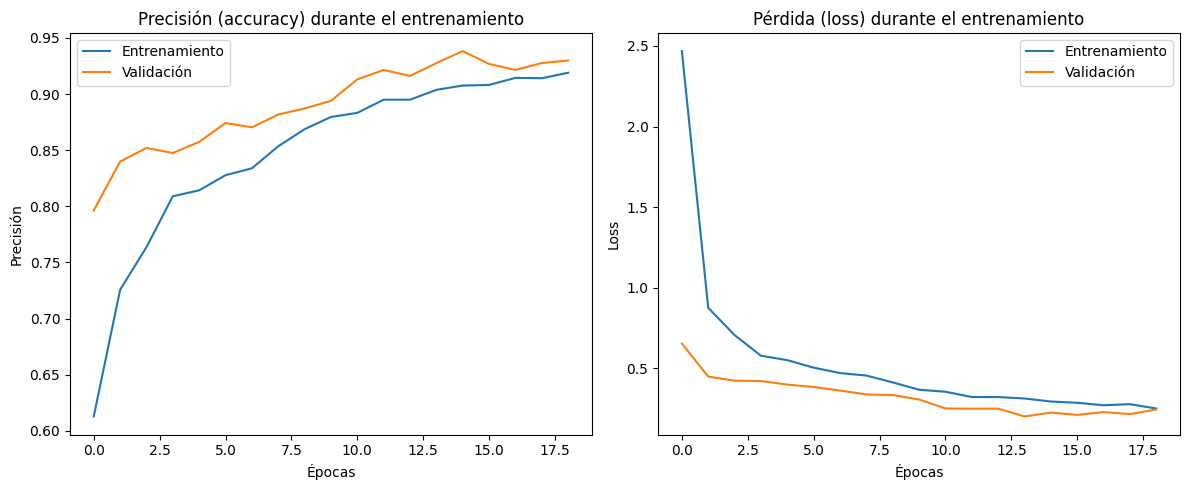

In [ ]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión (accuracy) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (loss) durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


###Prueba

In [ ]:
# Obtener predicciones sobre todas las imágenes del test
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Mostrar las 15 primeras predicciones con sus verdaderas etiquetas
for i in range(30):
    print(f"Imagen {i+1}: Predicción = {class_names[y_pred[i]]} | Real = {class_names[y_true[i]]}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step
Imagen 1: Predicción = glioma | Real = glioma
Imagen 2: Predicción = glioma | Real = glioma
Imagen 3: Predicción = glioma | Real = glioma
Imagen 4: Predicción = glioma | Real = glioma
Imagen 5: Predicción = glioma | Real = glioma
Imagen 6: Predicción = meningioma | Real = glioma
Imagen 7: Predicción = glioma | Real = glioma
Imagen 8: Predicción = glioma | Real = glioma
Imagen 9: Predicción = glioma | Real = glioma
Imagen 10: Predicción = glioma | Real = glioma
Imagen 11: Predicción = glioma | Real = glioma
Imagen 12: Predicción = glioma | Real = glioma
Imagen 13: Predicción = glioma | Real = glioma
Imagen 14: Predicción = glioma | Real = glioma
Imagen 15: Predicción = glioma | Real = glioma
Imagen 16: Predicción = glioma | Real = glioma
Imagen 17: Predicción = glioma | Real = glioma
Imagen 18: Predicción = glioma | Real = glioma
Imagen 19: Predicción = glioma | Real = glioma
Imagen 20: Predicción = glioma | Real = glioma
Imagen 21: Predicción = 

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step


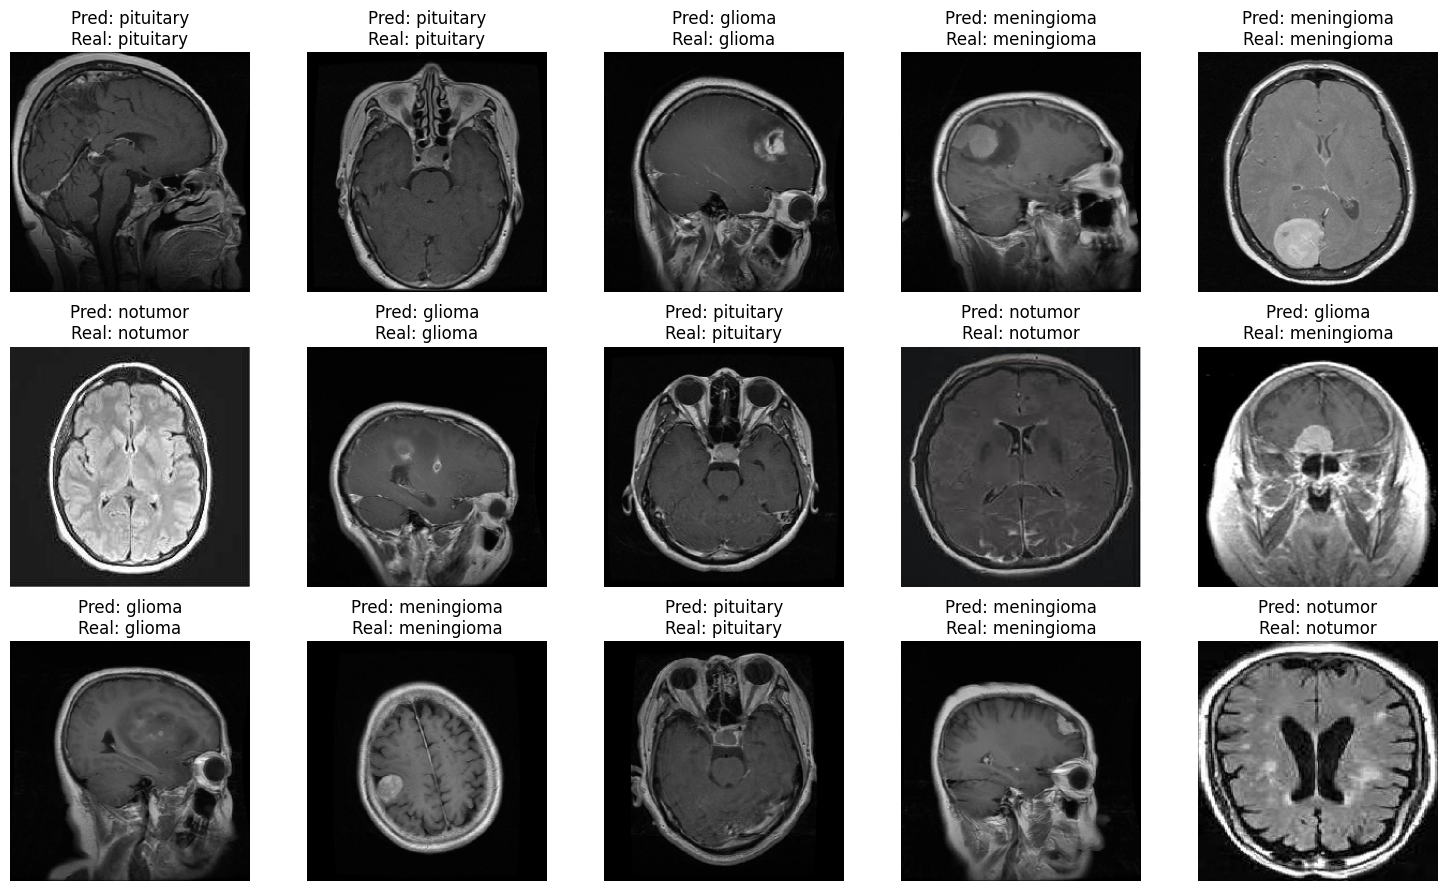

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Función para revertir el preprocesamiento de VGG16
def undo_vgg_preprocessing(x):
    x = x.copy()
    x[..., 0] += 103.939  # B
    x[..., 1] += 116.779  # G
    x[..., 2] += 123.68   # R
    return np.clip(x, 0, 255).astype("uint8")  # Limita valores y convierte

# Resetear el generador para empezar desde el principio
test_generator.reset()

# Obtener todas las imágenes y etiquetas del test set
X_all = []
y_all = []

for _ in range(len(test_generator)):
    X_batch, y_batch = next(test_generator)
    X_all.append(X_batch)
    y_all.append(y_batch)

# Convertir listas a arrays
X_all = np.concatenate(X_all)
y_all = np.concatenate(y_all)

# Obtener predicciones del modelo (si no las tenés ya)
y_pred_probs = model.predict(X_all)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_all, axis=1)

# Elegir 15 índices aleatorios
np.random.seed(42)
random_indices = np.random.choice(len(X_all), 15, replace=False)

# Mostrar imágenes corregidas
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
axs = axs.ravel()

for i, idx in enumerate(random_indices):
    img = undo_vgg_preprocessing(X_all[idx])
    axs[i].imshow(img)
    axs[i].set_title(f"Pred: {class_names[y_pred[idx]]}\nReal: {class_names[y_true[idx]]}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


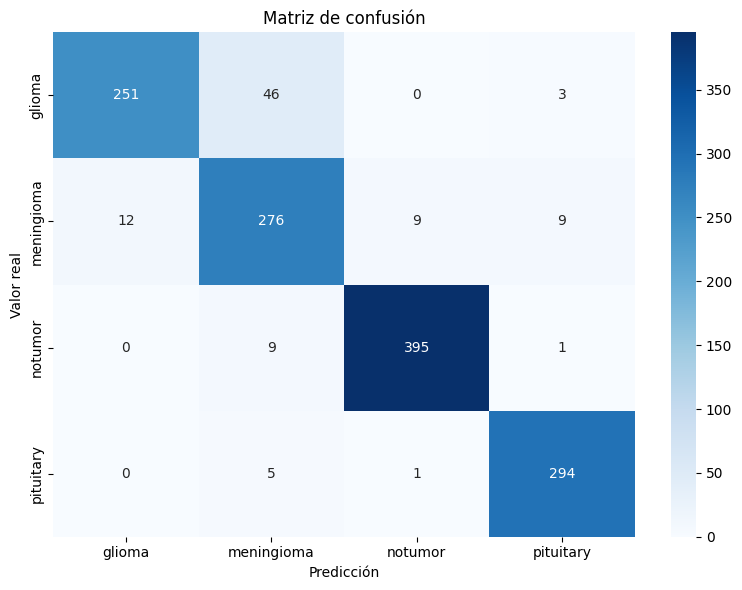

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Graficar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión')
plt.tight_layout()
plt.show()

In [ ]:
# Índices donde la predicción fue incorrecta
errores = np.where(y_pred != y_true)[0]

# Volvemos a reiniciar el generador para acceder a imágenes
test_generator.reset()

# Recorremos el generador hasta recolectar los errores
imagenes_erroneas = []
predicciones_erroneas = []
reales_erroneas = []

i = 0
for batch_imgs, batch_labels in test_generator:
    for j in range(len(batch_imgs)):
        if i in errores:
            imagenes_erroneas.append(batch_imgs[j])
            predicciones_erroneas.append(y_pred[i])
            reales_erroneas.append(y_true[i])
        i += 1
        if len(imagenes_erroneas) >= 9:
            break
    if len(imagenes_erroneas) >= 9:
        break


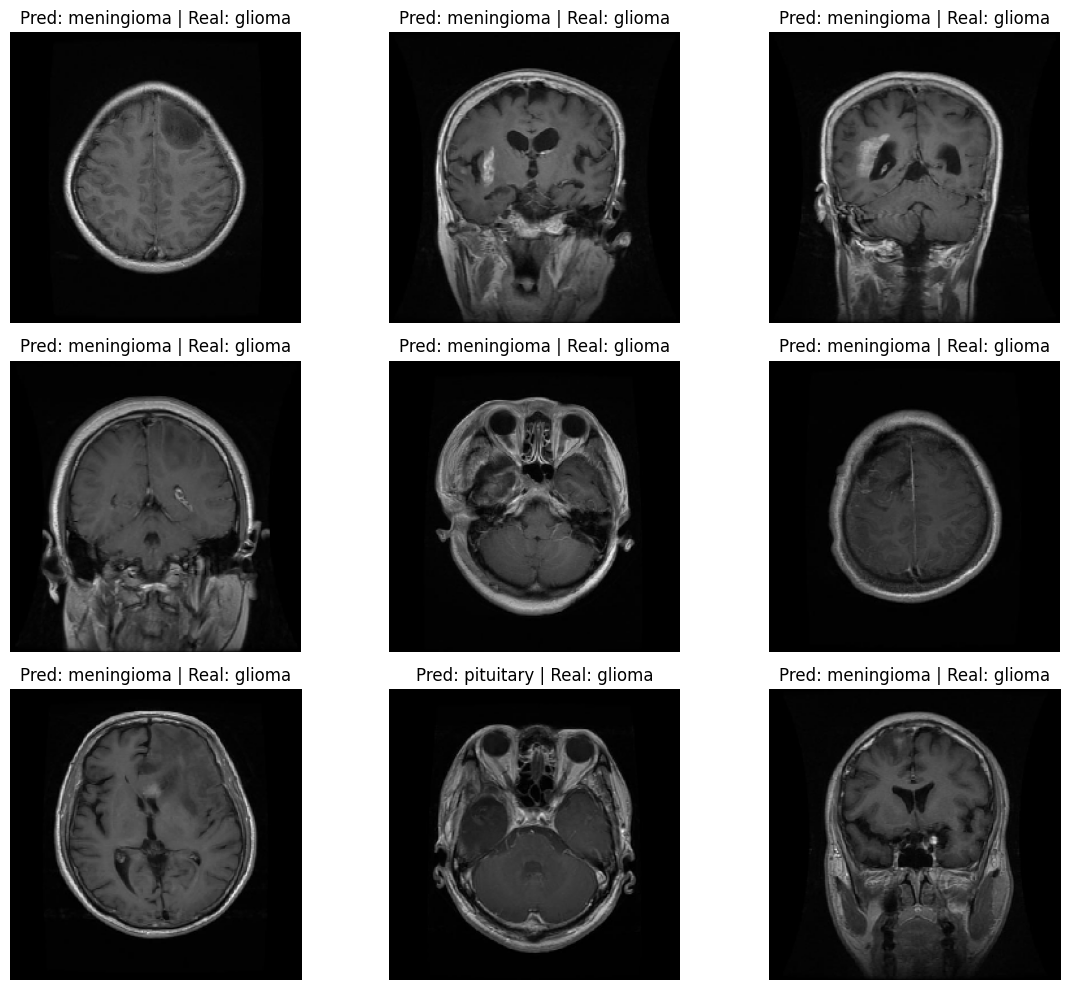

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Función para deshacer el preprocesamiento de VGG16
def undo_vgg_preprocessing(x):
    x = x.copy()
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    return np.clip(x, 0, 255).astype("uint8")

# Mostrar las imágenes de errores sin el título general
plt.figure(figsize=(12, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)

    img = undo_vgg_preprocessing(imagenes_erroneas[i])
    plt.imshow(img)
    plt.title(f"Pred: {class_names[predicciones_erroneas[i]]} | Real: {class_names[reales_erroneas[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Reporte de clasificación:\n")
print(report)

Reporte de clasificación:

              precision    recall  f1-score   support

      glioma       0.93      0.87      0.90       300
  meningioma       0.86      0.82      0.84       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



# Conclusiones
*  Se utilizó el modelo VGG16 preentrenado con transferencia de aprendizaje para clasificar tumores cerebrales en imágenes de RMN.
*   Al personalizar la salida y congelar las capas convolucionales, se logró una precisión del 92%, con buen desempeño en todas las clases.
*   El uso de data augmentation mejoró la generalización; sin él, el modelo presentaba menor rendimiento. EarlyStopping fue útil para evitar overfitting al detener el entrenamiento cuando la validación dejaba de mejorar.
*   Los resultados muestran que las CNN son efectivas para tareas de diagnóstico asistido por imágenes médicas.